In [9]:
'''
匯入套件
'''

# 操作 browser 的 API
from selenium import webdriver
from selenium.webdriver.chrome.service import Service

# 處理逾時例外的工具
from selenium.common.exceptions import TimeoutException

# 面對動態網頁，等待某個元素出現的工具，通常與 exptected_conditions 搭配
from selenium.webdriver.support.ui import WebDriverWait

# 搭配 WebDriverWait 使用，對元素狀態的一種期待條件，若條件發生，則等待結束，往下一行執行
from selenium.webdriver.support import expected_conditions as EC

# 期待元素出現要透過什麼方式指定，通常與 EC、WebDriverWait 一起使用
from selenium.webdriver.common.by import By

# 強制等待 (執行期間休息一下)
from time import sleep

# 美麗湯
from bs4 import BeautifulSoup as bs

# 整理 json 使用的工具
import json

#正規表達式
import re

# 發送請求
import requests

# 讀取清單
import csv

# 整理時間格式
from datetime import datetime, timezone

# 執行 command 的時候用的
import os

In [ ]:
'''
建立類別
'''

class GoogleMapScraper:
    # 建構子
    def __init__(self):
        # 開啟瀏覽器
        self.driver = self._init_driver()
        # 先開啟 Google Maps
        self.driver.get("https://www.google.com/maps?authuser=0")
        # 等待地圖加載
        sleep(5)
        # 爬取地點失敗log檔名
        self.failed_locations = "failed_locations.csv"
        # 用來存儲 google_2s 碼
        self.checkpoint_file = "google_2s_checkpoint.json"  

    # 開啟瀏覽器
    def _init_driver(self):
        # 啟動瀏覽器工具的選項
        my_options = webdriver.ChromeOptions()
        # my_options.add_argument("--headless")              #不開啟實體瀏覽器背景執行
        my_options.add_argument("--start-maximized")         #最大化視窗
        my_options.add_argument("--incognito")               #開啟無痕模式
        my_options.add_argument("--disable-popup-blocking")  #禁用彈出攔截
        my_options.add_argument("--disable-notifications")   #取消 chrome 推播通知
        my_options.add_argument("--lang=zh-TW")              #設定為正體中文
        my_options.add_argument(f"user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36")
        # 加入其他可能有用的隱私設定
        my_options.add_argument('--disable-blink-features=AutomationControlled')
        my_options.add_argument('--disable-extensions')
        my_options.add_experimental_option('excludeSwitches', ['enable-automation'])
        my_options.add_experimental_option('useAutomationExtension', False)
        # 使用 Chrome 的 WebDriver
        return webdriver.Chrome(options=my_options)
    
    # 爬取地點失敗log
    def log_failed_location(self, location, reason):
        with open(self.failed_locations, mode='a', encoding='utf-8', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([location, reason])
    
    # 搜尋地點
    def search_location(self, location: str):
        try:
            # 等待搜尋框出現
            WebDriverWait(self.driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, 'input#searchboxinput'))
            )
            # 尋找網頁中的搜尋框
            input_element = self.driver.find_element(By.CSS_SELECTOR, 'input#searchboxinput')
            
            # 在搜尋框中輸入文字
            input_element.clear()
            input_element.send_keys(location)

            # 睡個幾秒
            sleep(2)

            # 尋找送出按鈕
            clickButton = self.driver.find_element(
                By.CSS_SELECTOR, 'button#searchbox-searchbutton'
            )

            # 送出搜尋
            clickButton.click()

            # 睡個幾秒 等url跳轉為包含1s碼的url
            sleep(5)

            # 回傳包含1s碼的url
            return self.driver.current_url
        
        except:
            # 搜尋失敗紀錄
            print(f"{location}:搜尋失敗")
            self.log_failed_location(location, "搜尋失敗")
            return None
    
    # 取得地點的1s碼與身分驗證的KEI碼
    def extract_google_codes(self, url: str):
        try:
            # 用正則表達式轉換地點的1s碼
            google_1s = re.findall(r'0x\w+', url)
            if len(google_1s) >= 2:
                google_1s_code = f"{google_1s[0]}%3A{google_1s[1]}"
            else:
                return None, None
            
            # 取得身分驗證的KEI碼 在<head><script>中
            html = self.driver.page_source
            soup = bs(html, "lxml")
            # 取得第一個匹配結果
            google_kei_code = next((script.text.split("kEI='", 1)[1].split("'", 1)[0] for script in soup.find_all("script") if "kEI" in script.text), None)

            return google_1s_code, google_kei_code
        except:
            print(f"無法獲得1s碼")
            return None, None
    
    # 儲存當下的 google_2s 因應突發狀況
    def save_google_2s_checkpoint(self, google_2s, location):
        with open(self.checkpoint_file, 'w', encoding='utf-8') as file:
            json.dump({"google_2s": google_2s, "location": location}, file)

    # 接續上次的 google_2s 與地點 如果沒有則返回 None
    def load_google_2s_checkpoint(self):
        if os.path.exists(self.checkpoint_file):
            with open(self.checkpoint_file, 'r', encoding='utf-8') as file:
                data = json.load(file)
                return data.get("google_2s"), data.get("location")
        return None, None    
    
    # 抓取並寫入評論
    def fetch_reviews(self, google_1s, google_kei, location):
        # 讀取上次中斷爬取地點與2s碼
        google_2s, last_location = self.load_google_2s_checkpoint()
        # 如果是新的地點，則重置 google_2s 為空值
        if last_location != location:
            google_2s = ""
        # 不重複的評論ID
        unique_ids = set()
        # 總評論數
        total_reviews = 0
        # 有留言的評論數
        reviews_with_comments = 0
        # 頁數
        count = 1
        # 評論輸出檔名
        output_file = f"reviews_output_{location}.csv"
        
        while True:
            url = f'https://www.google.com/maps/rpc/listugcposts?authuser=0&hl=zh-TW&gl=tw&pb=!1m6!1s{google_1s}!6m4!4m1!1e1!4m1!1e3!2m2!1i10!2s{google_2s}!5m2!1s{google_kei}!7e81!8m9!2b1!3b1!5b1!7b1!12m4!1b1!2b1!4m1!1e1!11m0!13m1!1e2'
            response = requests.get(url)
            response.raise_for_status()
            raw_content = response.text.strip()
            
            # 處理防爬蟲字串
            if raw_content.startswith(")]}'"):
                raw_content = raw_content[4:]
            
            # 轉為json格式
            data = json.loads(raw_content)
            

            # 輸出每一頁評論
            with open(output_file, mode='a', encoding='utf-8', newline='') as file:
                writer = csv.writer(file)
                for review in data[2]:
                    try:
                        user = review[0][1][4][5][0]
                        user_id = review[0][1][4][5][3]
                        user_page = review[0][1][4][2][0]
                        review_id = str(review[0][0])
                        rating = str(review[0][2][0][0])
                        timestamp = datetime.fromtimestamp(review[0][1][2] // 1000000, tz=timezone.utc).strftime('%Y-%m-%d')
                        
                        # 只有評分的評論內容相關變數都要清空
                        try:
                            comment = review[0][2][15][0][0]
                        except:
                            comment = ""

                        try:                   
                            language = review[0][2][14][0]
                        except:
                            language = ""

                        try:
                            translated_comment = review[0][2][15][1][0]
                        except:
                            translated_comment = ""

                        # 評論ID不重複才寫入
                        if review_id not in unique_ids:
                            writer.writerow([user, user_id,review_id, rating, timestamp, comment, language, translated_comment,user_page])
                            unique_ids.add(review_id)
                            total_reviews += 1
                            if comment.strip():
                                reviews_with_comments += 1
                    except:
                        print(f"無法該筆爬取評論")
            print(f"現在在第 {count} 頁")
            print(f"總共存入 {total_reviews} 筆評論")
            print(f"其中有 {reviews_with_comments} 筆評論有內文")
            count += 1

            # 處理2s碼
            try:
                google_2s = data[1].replace('=', '%3D')
            except:
                print("沒有下一頁")
                break
            
            # 儲存最新的 google_2s
            self.save_google_2s_checkpoint(google_2s, location)
            
        if total_reviews == 0:
            self.log_failed_location(location, "沒有任何評論")

    def scrape_from_csv(self, input_file):
        with open(input_file, mode='r', encoding='utf-8') as file:
            csv_reader = csv.reader(file)
            locations = list(csv_reader)
        for row in locations:
            if row:
                location = row[0]
                print(f"開始爬取 {location}")
                url = self.search_location(location)
                if url:
                    google_1s, google_kei = self.extract_google_codes(url)
                    if google_1s and google_kei:
                        self.fetch_reviews(google_1s, google_kei, location)
                        print(f'{location} 已爬取完成')
                    else:
                        self.log_failed_location(location, "無法獲得1s碼")

    # 關閉瀏覽器
    def close_driver(self):
        self.driver.quit()

In [ ]:
# 開啟瀏覽器
scraper = GoogleMapScraper()

In [ ]:

# 實際爬蟲步驟 只需要給location list 的 csv檔
scraper.scrape_from_csv("google_maps_locations.csv")

In [ ]:

# 等確定擷取流程結束後，再手動關閉瀏覽器，以便 debug，減少瀏覽器開開關關
scraper.close_driver()

In [16]:
import pandas as pd

# 基本讀取
# 如果有中文，建議使用 utf-8 編碼
df = pd.read_csv('gmap838_reviews (1).csv', encoding='utf-8')

In [18]:
# 查看前 5 行
print(df.head())

# 查看基本信息
print(df.info())

# 查看欄位名稱
print(df.columns)


          user_name                user_id  \
0               林哲豪  107033607967130169527   
1         桃'S不專業評論家  109810548777046220231   
2               邱虹瑾  111670149432971678560   
3  พีรพัฒน์ นามวงศ์  108040471829753419555   
4               王鴻義  108981817540365799893   

                              review_id  score        date  \
0   ChZDSUhNMG9nS0VJQ0FnTURBMUttdUZnEAE      4  2025-02-07   
1  ChdDSUhNMG9nS0VJQ0FnSUNyelpxT3hnRRAB      4  2024-07-10   
2  ChdDSUhNMG9nS0VJQ0FnTUNBbF82Vy1BRRAB      5  2025-02-05   
3   ChZDSUhNMG9nS0VJQ0FnTUNBbmFibVZ3EAE      4  2025-02-03   
4  ChdDSUhNMG9nS0VJQ0FnSUQyNk51RWhBRRAB      5  2022-05-05   

                                            comments language  \
0           來參觀陶瓷博物館，可以了解台灣陶瓷的演進史，和現代陶瓷應用，讓我增加對陶瓷的知識  zh-Hant   
1  補21年照片\n好希望這個活動能一直辦下去~\n每年都想來看看大家的創意巧手~\n-----...  zh-Hant   
2                             蠻少人的 很好逛 能了解很多陶瓷的相關歷史！  zh-Hant   
3                                                NaN      NaN   
4                        

In [24]:
print(df['comments'][0])

來參觀陶瓷博物館，可以了解台灣陶瓷的演進史，和現代陶瓷應用，讓我增加對陶瓷的知識


C:\Users\student\AppData\Local\Temp\ipykernel_9528\1030262855.py:47: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\student\AppData\Local\Temp\ipykernel_9528\1030262855.py:47: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\student\AppData\Local\Temp\ipykernel_9528\1030262855.py:47: UserWarning: Glyph 33258 (\N{CJK UNIFIED IDEOGRAPH-81EA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\student\AppData\Local\Temp\ipykernel_9528\1030262855.py:47: UserWarning: Glyph 28982 (\N{CJK UNIFIED IDEOGRAPH-7136}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\student\AppData\Local\Temp\ipykernel_9528\1030262855.py:47: UserWarning: Glyph 32654 (\N{CJK UNIFIED IDEOGRAPH-7F8E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\student\AppData\Local\Temp\ipykernel_9528\1030262855.py:47: UserWarning: Glyph 39

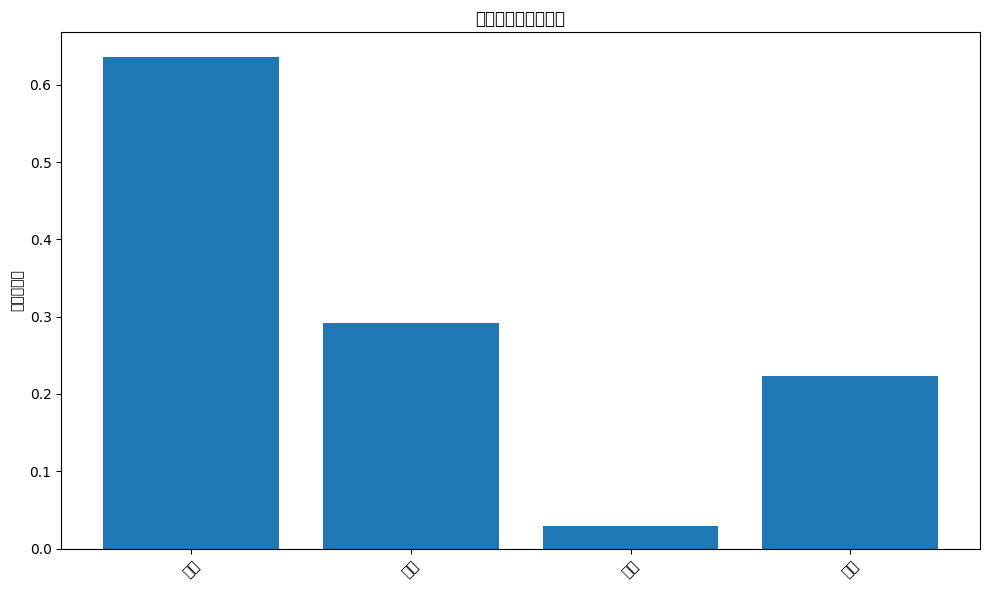

關鍵字語意向量：
文化: 0.636
自然: 0.292
美食: 0.029
購物: 0.223


In [11]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# 模擬關鍵字語意向量
class SemanticExtractor:
    def __init__(self):
        # 模擬語意類別
        self.categories = {
            '文化': ['博物館', '古蹟', '寺廟', '藝術館'],
            '自然': ['公園', '海灘', '山脈', '森林'],
            '美食': ['餐廳', '小吃', '夜市', '美食街'],
            '購物': ['商場', '街市', '百貨', '市集']
        }
        
        # 為每個關鍵字創建語意向量
        self.semantic_vectors = {}
        for category, words in self.categories.items():
            for word in words:
                # 創建一個基本向量，對應類別位置為1，其他為0
                vector = np.zeros(len(self.categories))
                vector[list(self.categories.keys()).index(category)] = 1
                # 添加一些隨機噪聲使其更自然
                vector += np.random.normal(0, 0.1, len(self.categories))
                vector = np.clip(vector, 0, 1)  # 確保值在0-1之間
                self.semantic_vectors[word] = vector
                
    def extract_semantics(self, keywords):
        # 組合所有關鍵字的語意向量
        combined_vector = np.zeros(len(self.categories))
        for keyword in keywords:
            if keyword in self.semantic_vectors:
                combined_vector += self.semantic_vectors[keyword]
        return combined_vector / (len(keywords) if keywords else 1)

# 示例使用
extractor = SemanticExtractor()
keywords = ['博物館', '寺廟', '公園']
semantic_vector = extractor.extract_semantics(keywords)

# 視覺化語意向量
plt.figure(figsize=(10, 6))
plt.bar(list(extractor.categories.keys()), semantic_vector)
plt.title('關鍵字語意向量分析')
plt.ylabel('語意關聯度')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 打印語意向量
print("關鍵字語意向量：")
for category, value in zip(extractor.categories.keys(), semantic_vector):
    print(f"{category}: {value:.3f}")

C:\Users\student\AppData\Local\Temp\ipykernel_9528\2565578566.py:59: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\student\AppData\Local\Temp\ipykernel_9528\2565578566.py:59: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\student\AppData\Local\Temp\ipykernel_9528\2565578566.py:59: UserWarning: Glyph 33258 (\N{CJK UNIFIED IDEOGRAPH-81EA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\student\AppData\Local\Temp\ipykernel_9528\2565578566.py:59: UserWarning: Glyph 28982 (\N{CJK UNIFIED IDEOGRAPH-7136}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\student\AppData\Local\Temp\ipykernel_9528\2565578566.py:59: UserWarning: Glyph 32654 (\N{CJK UNIFIED IDEOGRAPH-7F8E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\student\AppData\Local\Temp\ipykernel_9528\2565578566.py:59: UserWarning: Glyph 39

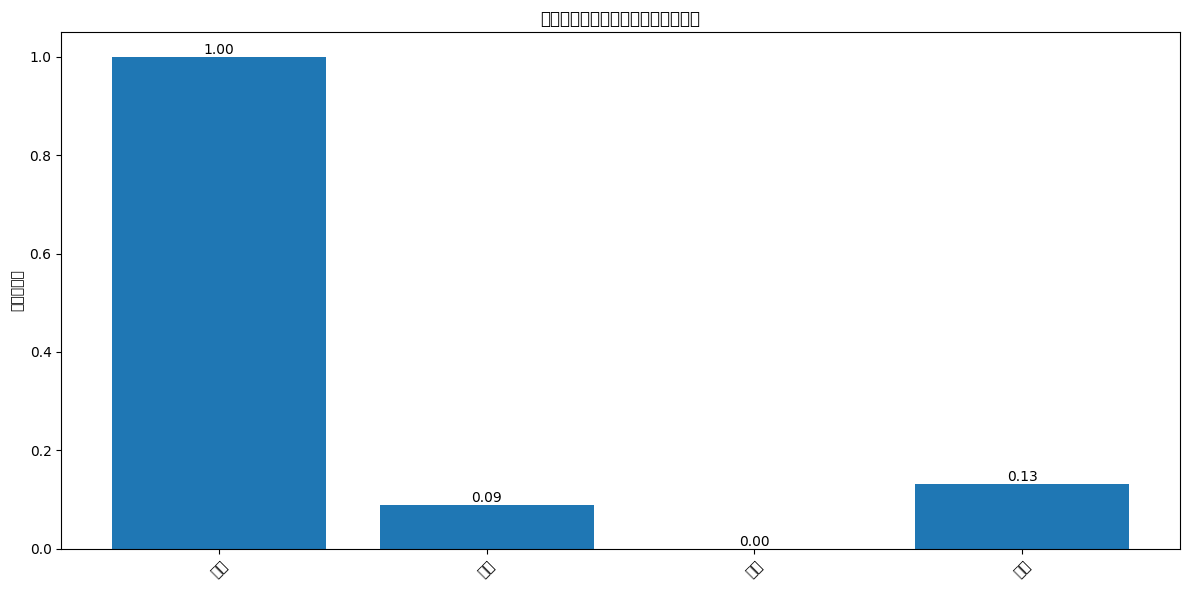


語意分析結果：
文化: 1.000
自然: 0.089
美食: 0.000
購物: 0.132

主要語意傾向：
- 文化 (關聯度: 1.000)


In [28]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

class SemanticExtractor:
    def __init__(self):
        # 擴充語意類別，加入更符合陶瓷博物館相關的類別
        self.categories = {
            '文化': ['博物館', '古蹟', '寺廟', '藝術館'],
            '自然': ['公園', '海灘', '山脈', '森林'],
            '美食': ['餐廳', '小吃', '夜市', '美食街'],
            '購物': ['商場', '街市', '百貨', '市集']
        }
        
        # 為每個關鍵字創建語意向量
        self.semantic_vectors = {}
        for category, words in self.categories.items():
            for word in words:
                vector = np.zeros(len(self.categories))
                vector[list(self.categories.keys()).index(category)] = 1
                vector += np.random.normal(0, 0.1, len(self.categories))
                vector = np.clip(vector, 0, 1)
                self.semantic_vectors[word] = vector
                
    def extract_semantics(self, text):
        # 將輸入文字分解為關鍵字
        keywords = []
        for category_words in self.categories.values():
            for word in category_words:
                if word in text:
                    keywords.append(word)
        
        # 組合所有找到的關鍵字的語意向量
        combined_vector = np.zeros(len(self.categories))
        for keyword in keywords:
            if keyword in self.semantic_vectors:
                combined_vector += self.semantic_vectors[keyword]
        return combined_vector / (len(keywords) if keywords else 1)

# 分析文本
text = "來參觀陶瓷博物館，可以了解台灣陶瓷的演進史，和現代陶瓷應用，讓我增加對陶瓷的知識"
extractor = SemanticExtractor()
semantic_vector = extractor.extract_semantics(text)

# 視覺化語意向量
plt.figure(figsize=(12, 6))
bars = plt.bar(list(extractor.categories.keys()), semantic_vector)
plt.title('陶瓷博物館相關文本的語意向量分析')
plt.ylabel('語意關聯度')
plt.xticks(rotation=45)

# 添加數值標籤
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 打印語意向量和分析結果
print("\n語意分析結果：")
for category, value in zip(extractor.categories.keys(), semantic_vector):
    print(f"{category}: {value:.3f}")

# 找出主要語意傾向
main_categories = sorted(zip(extractor.categories.keys(), semantic_vector), 
                        key=lambda x: x[1], reverse=True)
print("\n主要語意傾向：")
for category, value in main_categories:
    if value > 0.3:  # 設定閾值
        print(f"- {category} (關聯度: {value:.3f})")

C:\Users\student\AppData\Local\Temp\ipykernel_9528\3640363061.py:65: UserWarning: Glyph 22283 (\N{CJK UNIFIED IDEOGRAPH-570B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\student\AppData\Local\Temp\ipykernel_9528\3640363061.py:65: UserWarning: Glyph 31435 (\N{CJK UNIFIED IDEOGRAPH-7ACB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\student\AppData\Local\Temp\ipykernel_9528\3640363061.py:65: UserWarning: Glyph 25925 (\N{CJK UNIFIED IDEOGRAPH-6545}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\student\AppData\Local\Temp\ipykernel_9528\3640363061.py:65: UserWarning: Glyph 23470 (\N{CJK UNIFIED IDEOGRAPH-5BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\student\AppData\Local\Temp\ipykernel_9528\3640363061.py:65: UserWarning: Glyph 21338 (\N{CJK UNIFIED IDEOGRAPH-535A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\student\AppData\Local\Temp\ipykernel_9528\3640363061.py:65: UserWarning: Glyph 29

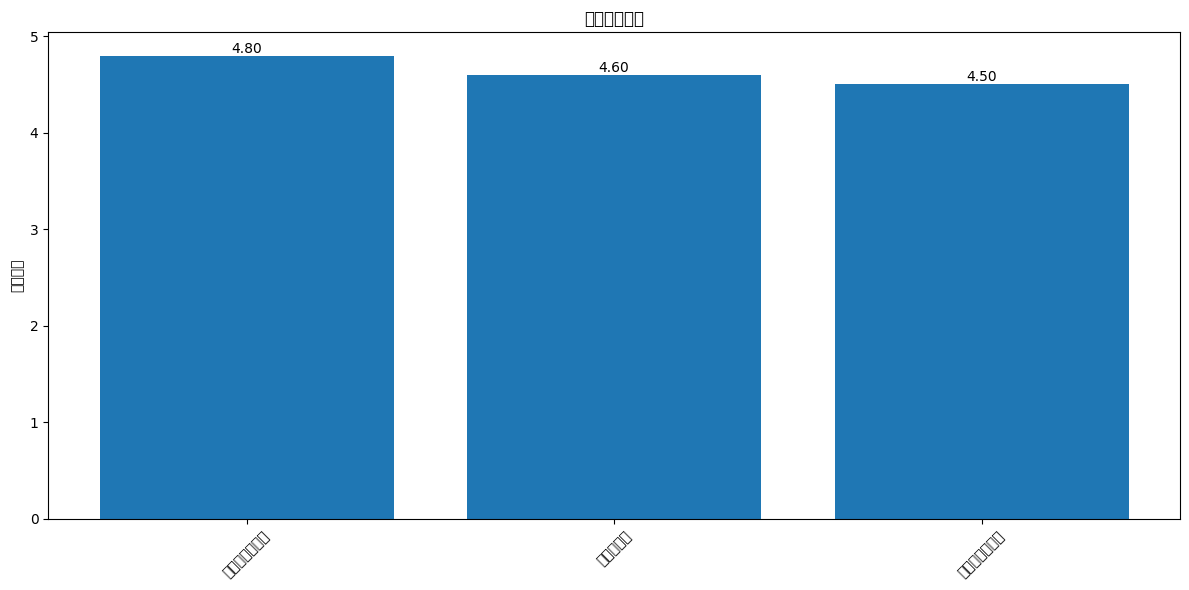


推薦景點：

國立故宮博物院
推薦分數: 4.80
評分: 4.8
關鍵字: 博物館, 文物, 藝術

朱銘美術館
推薦分數: 4.60
評分: 4.6
關鍵字: 藝術, 雕塑, 美術館

鶯歌陶瓷博物館
推薦分數: 4.50
評分: 4.5
關鍵字: 陶瓷, 博物館, 藝術


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

class TravelRecommender:
    def __init__(self):
        # 景點資料庫
        self.attractions = {
            '文化': {
                '國立故宮博物院': {'rating': 4.8, 'keywords': ['博物館', '文物', '藝術']},
                '鶯歌陶瓷博物館': {'rating': 4.5, 'keywords': ['陶瓷', '博物館', '藝術']},
                '十三行博物館': {'rating': 4.3, 'keywords': ['歷史', '博物館', '文化']},
                '朱銘美術館': {'rating': 4.6, 'keywords': ['藝術', '雕塑', '美術館']},
            },
            '自然': {
                '陽明山國家公園': {'rating': 4.7, 'keywords': ['公園', '山脈', '溫泉']},
                '福山植物園': {'rating': 4.4, 'keywords': ['森林', '生態', '步道']},
            },
            '美食': {
                '饒河街觀光夜市': {'rating': 4.2, 'keywords': ['夜市', '小吃', '美食']},
                '士林夜市': {'rating': 4.3, 'keywords': ['夜市', '美食', '購物']},
            },
            '購物': {
                '台北101': {'rating': 4.6, 'keywords': ['商場', '百貨', '景點']},
                '西門町': {'rating': 4.1, 'keywords': ['商圈', '街市', '美食']},
            }
        }
        
    def recommend(self, semantic_vector, categories, top_n=3):
        # 計算每個景點的推薦分數
        scores = defaultdict(float)
        for cat, value in zip(categories, semantic_vector):
            if value > 0:  # 只考慮有關聯的類別
                for spot, info in self.attractions[cat].items():
                    # 結合語意分數和景點評分
                    scores[spot] = value * info['rating']
        
        # 排序並返回前N個推薦
        recommendations = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        return recommendations[:top_n]

# 使用之前的語意分析結果
semantic_vector = np.array([1.000, 0.089, 0.000, 0.132])
categories = ['文化', '自然', '美食', '購物']

# 創建推薦器並獲取推薦
recommender = TravelRecommender()
recommendations = recommender.recommend(semantic_vector, categories)

# 視覺化推薦結果
plt.figure(figsize=(12, 6))
spots, scores = zip(*recommendations)
bars = plt.bar(spots, scores)
plt.title('推薦景點評分')
plt.ylabel('推薦分數')
plt.xticks(rotation=45)

# 添加數值標籤
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 打印詳細推薦結果
print("\n推薦景點：")
for spot, score in recommendations:
    print(f"\n{spot}")
    print(f"推薦分數: {score:.2f}")
    print(f"評分: {recommender.attractions[next(cat for cat, spots in recommender.attractions.items() if spot in spots)][spot]['rating']}")
    print(f"關鍵字: {', '.join(recommender.attractions[next(cat for cat, spots in recommender.attractions.items() if spot in spots)][spot]['keywords'])}")
    

C:\Users\student\anaconda3\envs\dl\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24231 (\N{CJK UNIFIED IDEOGRAPH-5EA7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\student\anaconda3\envs\dl\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\student\anaconda3\envs\dl\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25512 (\N{CJK UNIFIED IDEOGRAPH-63A8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\student\anaconda3\envs\dl\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 34214 (\N{CJK UNIFIED IDEOGRAPH-85A6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\student\anaconda3\envs\dl\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26053 (\N{CJK UNIFIE

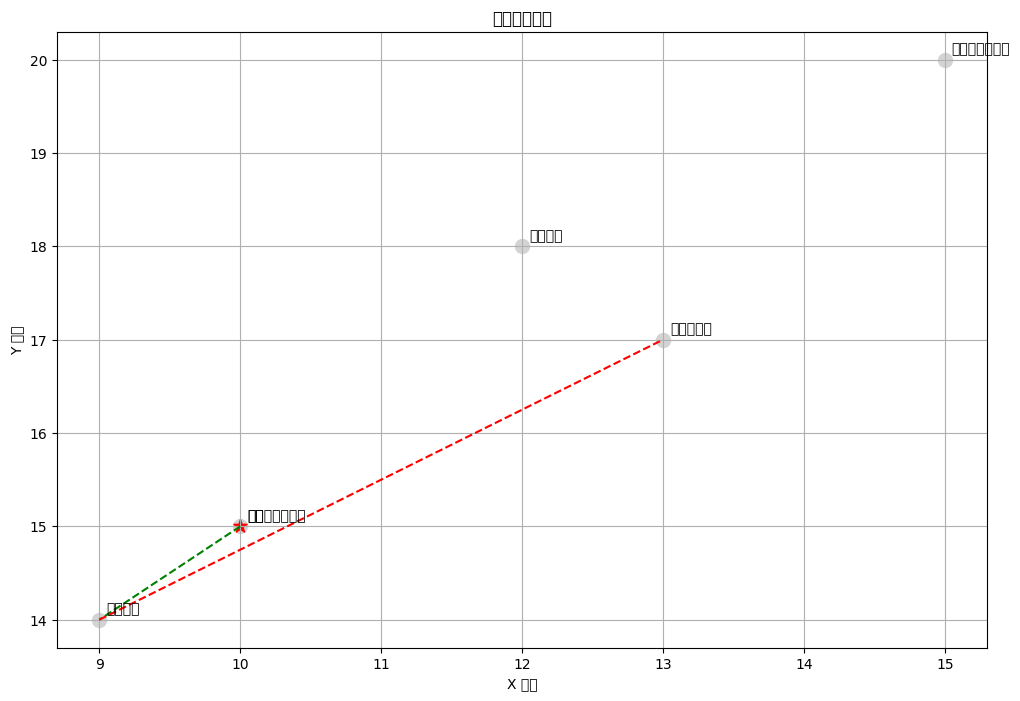


推薦路徑：
起點: 鶯歌陶瓷博物館 ((10, 15))

1. 鶯歌陶瓷博物館
   距離: 0.00 km
   評分: 4.5
   價格: $50
   預計遊覽時間: 2.5 小時
   綜合得分: 1.80

2. 鶯歌老街
   距離: 1.41 km
   評分: 4.2
   價格: $0
   預計遊覽時間: 2.0 小時
   綜合得分: 1.26

3. 三峽祖師廟
   距離: 3.61 km
   評分: 4.4
   價格: $0
   預計遊覽時間: 1.0 小時
   綜合得分: 0.68


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

class TravelPathRecommender:
    def __init__(self):
        # 景點資料庫：包含位置(x,y)、評分、價格等資訊
        self.attractions = {
            '鶯歌陶瓷博物館': {
                'location': (10, 15),
                'rating': 4.5,
                'price': 50,
                'visit_time': 2.5,
                'category': '文化'
            },
            '三峽老街': {
                'location': (12, 18),
                'rating': 4.3,
                'price': 0,
                'visit_time': 1.5,
                'category': '文化'
            },
            '鶯歌老街': {
                'location': (9, 14),
                'rating': 4.2,
                'price': 0,
                'visit_time': 2.0,
                'category': '文化'
            },
            '三峽祖師廟': {
                'location': (13, 17),
                'rating': 4.4,
                'price': 0,
                'visit_time': 1.0,
                'category': '文化'
            },
            '大板根森林溫泉': {
                'location': (15, 20),
                'rating': 4.6,
                'price': 800,
                'visit_time': 4.0,
                'category': '自然'
            }
        }
    
    def calculate_distance(self, point1, point2):
        return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
    
    def dominates(self, p1, p2):
        """檢查p1是否支配p2（天際線原則）"""
        # 比較三個維度：距離（越小越好）、評分（越大越好）、價格（越小越好）
        return (p1['distance'] <= p2['distance'] and 
                p1['rating'] >= p2['rating'] and 
                p1['price'] <= p2['price'] and 
                (p1['distance'] < p2['distance'] or 
                 p1['rating'] > p2['rating'] or 
                 p1['price'] < p2['price']))
    
    def skyline_query(self, start_point, candidates):
        """執行天際線查詢"""
        skyline = []
        for i, p1 in enumerate(candidates):
            is_dominated = False
            for p2 in candidates:
                if p1 != p2 and self.dominates(p2, p1):
                    is_dominated = True
                    break
            if not is_dominated:
                skyline.append(p1)
        return skyline
    
    def recommend_path(self, start_location, max_spots=3):
        # 計算每個景點相對於起點的資訊
        candidates = []
        for name, info in self.attractions.items():
            distance = self.calculate_distance(start_location, info['location'])
            candidates.append({
                'name': name,
                'distance': distance,
                'rating': info['rating'],
                'price': info['price'],
                'location': info['location'],
                'visit_time': info['visit_time']
            })
        
        # 使用天際線查詢找出最佳選擇
        skyline_spots = self.skyline_query(start_location, candidates)
        
        # 根據綜合得分排序（這裡使用簡單的加權和）
        for spot in skyline_spots:
            spot['score'] = (spot['rating'] * 0.4 - 
                           spot['distance'] * 0.3 - 
                           spot['price'] * 0.0001)
        
        recommended_spots = sorted(skyline_spots, 
                                 key=lambda x: x['score'], 
                                 reverse=True)[:max_spots]
        
        return recommended_spots

# 測試系統
start_point = (10, 15)  # 假設從鶯歌陶瓷博物館出發
recommender = TravelPathRecommender()
recommendations = recommender.recommend_path(start_point)

# 視覺化推薦路徑
plt.figure(figsize=(12, 8))

# 繪製所有景點
for name, info in recommender.attractions.items():
    x, y = info['location']
    plt.scatter(x, y, c='lightgray', s=100)
    plt.annotate(name, (x, y), xytext=(5, 5), textcoords='offset points')

# 繪製起點
plt.scatter(start_point[0], start_point[1], c='red', s=100, marker='*')
plt.annotate('起點', start_point, xytext=(5, 5), textcoords='offset points')

# 繪製推薦路徑
current_point = start_point
colors = ['b', 'g', 'r']
for i, spot in enumerate(recommendations):
    plt.plot([current_point[0], spot['location'][0]], 
             [current_point[1], spot['location'][1]], 
             c=colors[i], linestyle='--')
    current_point = spot['location']

plt.title('推薦旅遊路徑')
plt.xlabel('X 座標')
plt.ylabel('Y 座標')
plt.grid(True)
plt.show()

# 打印推薦結果
print("\n推薦路徑：")
print(f"起點: 鶯歌陶瓷博物館 ({start_point})")
for i, spot in enumerate(recommendations, 1):
    print(f"\n{i}. {spot['name']}")
    print(f"   距離: {spot['distance']:.2f} km")
    print(f"   評分: {spot['rating']}")
    print(f"   價格: ${spot['price']}")
    print(f"   預計遊覽時間: {spot['visit_time']} 小時")
    print(f"   綜合得分: {spot['score']:.2f}")

C:\Users\student\anaconda3\envs\dl\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32239 (\N{CJK UNIFIED IDEOGRAPH-7DEF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\student\anaconda3\envs\dl\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\student\anaconda3\envs\dl\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21488 (\N{CJK UNIFIED IDEOGRAPH-53F0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\student\anaconda3\envs\dl\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21271 (\N{CJK UNIFIED IDEOGRAPH-5317}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\student\anaconda3\envs\dl\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24066 (\N{CJK UNIFIE

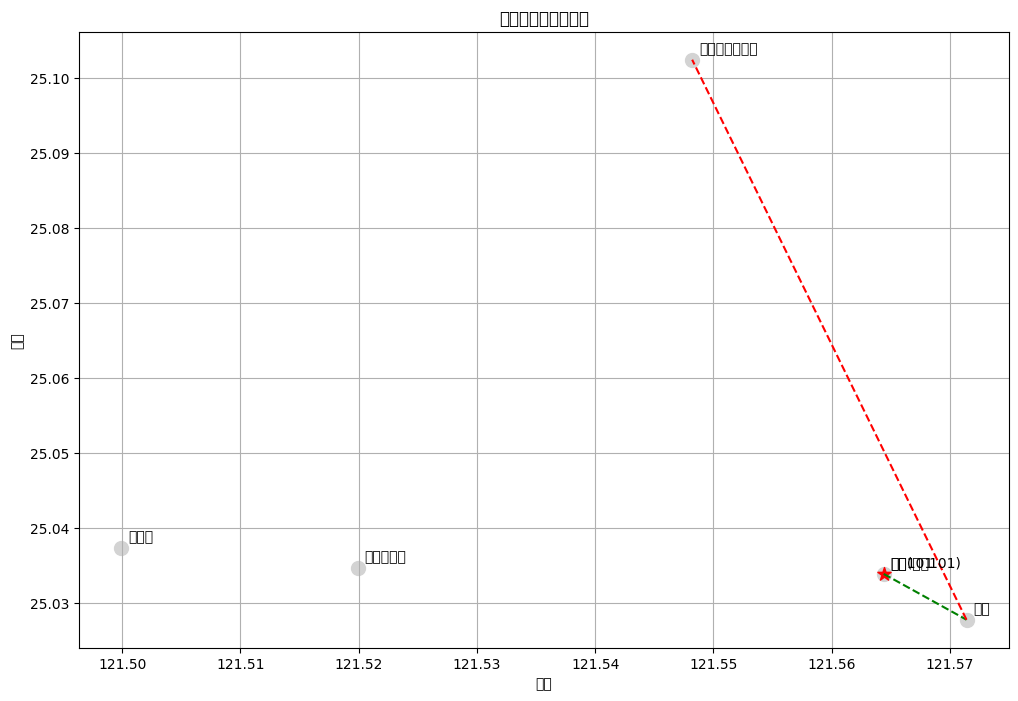


推薦路徑：
起點: 台北101 ((25.0339, 121.5644))

1. 台北101
   距離: 0.00 km
   評分: 4.7
   價格: $600
   預計遊覽時間: 2.0 小時
   經緯度: (25.0339, 121.5644)
   綜合得分: 1.82

2. 象山
   距離: 0.98 km
   評分: 4.6
   價格: $0
   預計遊覽時間: 2.0 小時
   經緯度: (25.0278, 121.5714)
   綜合得分: 1.55

3. 國立故宮博物院
   距離: 7.79 km
   評分: 4.8
   價格: $350
   預計遊覽時間: 3.0 小時
   經緯度: (25.1024, 121.5482)
   綜合得分: -0.45


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2

class TravelPathRecommender:
    def __init__(self):
        # 景點資料庫：包含經緯度、評分、價格等資訊
        self.attractions = {
            '台北101': {
                'coords': (25.0339, 121.5644),  # (緯度, 經度)
                'rating': 4.7,
                'price': 600,
                'visit_time': 2.0,
                'category': '地標'
            },
            '國立故宮博物院': {
                'coords': (25.1024, 121.5482),
                'rating': 4.8,
                'price': 350,
                'visit_time': 3.0,
                'category': '文化'
            },
            '中正紀念堂': {
                'coords': (25.0347, 121.5199),
                'rating': 4.6,
                'price': 0,
                'visit_time': 1.5,
                'category': '文化'
            },
            '龍山寺': {
                'coords': (25.0374, 121.4999),
                'rating': 4.5,
                'price': 0,
                'visit_time': 1.0,
                'category': '文化'
            },
            '象山': {
                'coords': (25.0278, 121.5714),
                'rating': 4.6,
                'price': 0,
                'visit_time': 2.0,
                'category': '自然'
            }
        }
    
    def haversine_distance(self, coord1, coord2):
        """計算兩點間的實際距離（公里）"""
        lat1, lon1 = coord1
        lat2, lon2 = coord2
        
        # 轉換為弧度
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        
        # Haversine 公式
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1-a))
        r = 6371  # 地球半徑（公里）
        
        return r * c
    
    def dominates(self, p1, p2):
        """檢查p1是否支配p2（天際線原則）"""
        return (p1['distance'] <= p2['distance'] and 
                p1['rating'] >= p2['rating'] and 
                p1['price'] <= p2['price'] and 
                (p1['distance'] < p2['distance'] or 
                 p1['rating'] > p2['rating'] or 
                 p1['price'] < p2['price']))
    
    def skyline_query(self, candidates):
        """執行天際線查詢"""
        skyline = []
        for p1 in candidates:
            is_dominated = False
            for p2 in candidates:
                if p1 != p2 and self.dominates(p2, p1):
                    is_dominated = True
                    break
            if not is_dominated:
                skyline.append(p1)
        return skyline
    
    def recommend_path(self, start_coords, max_spots=3):
        candidates = []
        for name, info in self.attractions.items():
            distance = self.haversine_distance(start_coords, info['coords'])
            candidates.append({
                'name': name,
                'distance': distance,
                'rating': info['rating'],
                'price': info['price'],
                'coords': info['coords'],
                'visit_time': info['visit_time']
            })
        
        skyline_spots = self.skyline_query(candidates)
        
        # 計算綜合得分
        for spot in skyline_spots:
            spot['score'] = (spot['rating'] * 0.4 - 
                           spot['distance'] * 0.3 - 
                           spot['price'] * 0.0001)
        
        recommended_spots = sorted(skyline_spots, 
                                 key=lambda x: x['score'], 
                                 reverse=True)[:max_spots]
        
        return recommended_spots

# 測試系統
start_coords = (25.0339, 121.5644)  # 以台北101為起點
recommender = TravelPathRecommender()
recommendations = recommender.recommend_path(start_coords)

# 視覺化推薦路徑
plt.figure(figsize=(12, 8))

# 繪製所有景點
for name, info in recommender.attractions.items():
    lat, lon = info['coords']
    plt.scatter(lon, lat, c='lightgray', s=100)
    plt.annotate(name, (lon, lat), xytext=(5, 5), textcoords='offset points')

# 繪製起點
plt.scatter(start_coords[1], start_coords[0], c='red', s=100, marker='*')
plt.annotate('起點(台北101)', (start_coords[1], start_coords[0]), 
            xytext=(5, 5), textcoords='offset points')

# 繪製推薦路徑
current_point = start_coords
colors = ['b', 'g', 'r']
for i, spot in enumerate(recommendations):
    plt.plot([current_point[1], spot['coords'][1]], 
             [current_point[0], spot['coords'][0]], 
             c=colors[i], linestyle='--')
    current_point = spot['coords']

plt.title('台北市景點推薦路徑')
plt.xlabel('經度')
plt.ylabel('緯度')
plt.grid(True)
plt.show()

# 打印推薦結果
print("\n推薦路徑：")
print(f"起點: 台北101 ({start_coords})")
for i, spot in enumerate(recommendations, 1):
    print(f"\n{i}. {spot['name']}")
    print(f"   距離: {spot['distance']:.2f} km")
    print(f"   評分: {spot['rating']}")
    print(f"   價格: ${spot['price']}")
    print(f"   預計遊覽時間: {spot['visit_time']} 小時")
    print(f"   經緯度: {spot['coords']}")
    print(f"   綜合得分: {spot['score']:.2f}")

C:\Users\student\anaconda3\envs\dl\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32239 (\N{CJK UNIFIED IDEOGRAPH-7DEF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\student\anaconda3\envs\dl\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\student\anaconda3\envs\dl\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21488 (\N{CJK UNIFIED IDEOGRAPH-53F0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\student\anaconda3\envs\dl\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21271 (\N{CJK UNIFIED IDEOGRAPH-5317}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\student\anaconda3\envs\dl\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24066 (\N{CJK UNIFIE

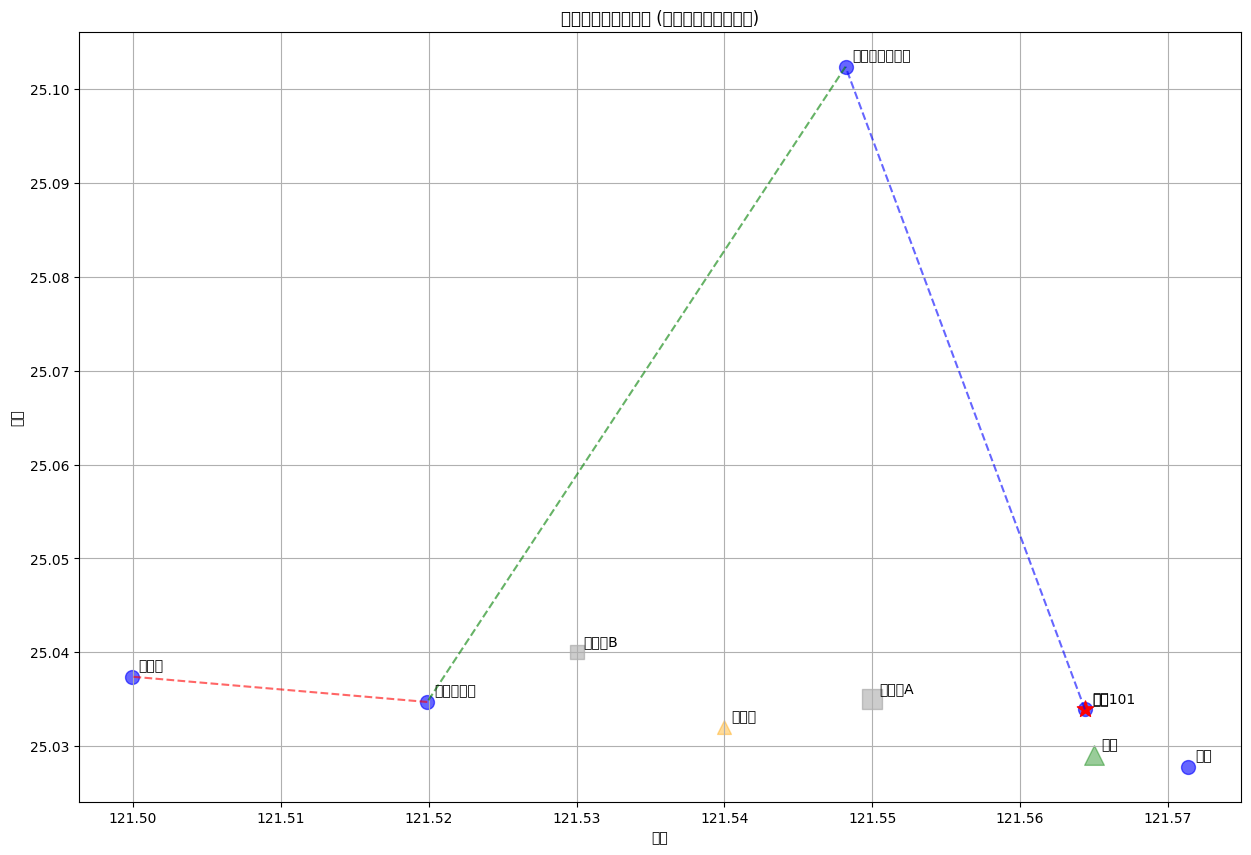


交通方式建議 (從台北101到故宮):
距離: 7.79 公里

捷運:
  評分: 4.7
  預計行程時間: 0.3 小時
  成本: $30

步行:
  評分: 2.5
  預計行程時間: 1.9 小時
  成本: $0

YouBike:
  評分: 2.4
  預計行程時間: 0.6 小時
  成本: $10

公車:
  評分: 1.9
  預計行程時間: 0.4 小時
  成本: $15

計程車:
  評分: 1.5
  預計行程時間: 0.2 小時
  成本: $250


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2

class EnhancedTravelPathRecommender:
    def __init__(self):
        # 景點資料庫
        self.attractions = {
            '台北101': {
                'coords': (25.0339, 121.5644),
                'rating': 4.7,
                'price': 600,
                'visit_time': 2.0,
                'category': '地標',
                'crowd_level': 'high'
            },
            '國立故宮博物院': {
                'coords': (25.1024, 121.5482),
                'rating': 4.8,
                'price': 350,
                'visit_time': 3.0,
                'category': '文化',
                'crowd_level': 'high'
            },
            '中正紀念堂': {
                'coords': (25.0347, 121.5199),
                'rating': 4.6,
                'price': 0,
                'visit_time': 1.5,
                'category': '文化',
                'crowd_level': 'medium'
            },
            '龍山寺': {
                'coords': (25.0374, 121.4999),
                'rating': 4.5,
                'price': 0,
                'visit_time': 1.0,
                'category': '文化',
                'crowd_level': 'medium'
            },
            '象山': {
                'coords': (25.0278, 121.5714),
                'rating': 4.6,
                'price': 0,
                'visit_time': 2.0,
                'category': '自然',
                'crowd_level': 'low'
            }
        }
        
        # 障礙物和建築物
        self.obstacles = {
            '建築群A': {
                'coords': (25.0350, 121.5500),
                'type': 'buildings',
                'size': 'large'
            },
            '建築群B': {
                'coords': (25.0400, 121.5300),
                'type': 'buildings',
                'size': 'medium'
            },
            '施工區': {
                'coords': (25.0320, 121.5400),
                'type': 'construction',
                'size': 'medium'
            },
            '山區': {
                'coords': (25.0290, 121.5650),
                'type': 'terrain',
                'size': 'large'
            }
        }
        
        # 交通方式資料
        self.transport_modes = {
            '步行': {
                'speed': 4,  # km/h
                'cost': 0,
                'eco_friendly': 5,
                'weather_dependent': True
            },
            '捷運': {
                'speed': 30,
                'cost': 30,
                'eco_friendly': 4,
                'weather_dependent': False
            },
            '公車': {
                'speed': 20,
                'cost': 15,
                'eco_friendly': 4,
                'weather_dependent': False
            },
            '計程車': {
                'speed': 35,
                'cost': 250,
                'eco_friendly': 2,
                'weather_dependent': False
            },
            'YouBike': {
                'speed': 12,
                'cost': 10,
                'eco_friendly': 5,
                'weather_dependent': True
            }
        }

    def haversine_distance(self, coord1, coord2):
        """計算兩點間的實際距離（公里）"""
        lat1, lon1 = coord1
        lat2, lon2 = coord2
        
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1-a))
        r = 6371
        
        return r * c

    def recommend_transport(self, distance, weather='sunny', time_of_day='day'):
        """根據距離和條件推薦交通方式"""
        recommendations = []
        
        for mode, info in self.transport_modes.items():
            score = 0
            travel_time = distance / info['speed']
            
            # 基於距離的評分
            if distance <= 1 and mode in ['步行', 'YouBike']:
                score += 5
            elif 1 < distance <= 5 and mode in ['YouBike', '公車', '捷運']:
                score += 4
            elif distance > 5 and mode in ['捷運', '計程車']:
                score += 3
                
            # 考慮天氣因素
            if info['weather_dependent'] and weather != 'sunny':
                score -= 2
                
            # 考慮成本效益
            score -= (info['cost'] / 100)
            
            # 加入環保因素
            score += info['eco_friendly'] * 0.5
            
            recommendations.append({
                'mode': mode,
                'score': score,
                'travel_time': travel_time,
                'cost': info['cost']
            })
            
        return sorted(recommendations, key=lambda x: x['score'], reverse=True)

    def plot_route(self, start_coords, recommendations):
        """繪製路線圖，包含障礙物和建築物"""
        plt.figure(figsize=(15, 10))
        
        # 繪製所有景點
        for name, info in self.attractions.items():
            lat, lon = info['coords']
            plt.scatter(lon, lat, c='blue', s=100, alpha=0.6)
            plt.annotate(name, (lon, lat), xytext=(5, 5), textcoords='offset points')

        # 繪製障礙物
        for name, info in self.obstacles.items():
            lat, lon = info['coords']
            if info['type'] == 'buildings':
                color = 'gray'
                marker = 's'
            elif info['type'] == 'construction':
                color = 'orange'
                marker = '^'
            else:
                color = 'green'
                marker = '^'
            
            size = 200 if info['size'] == 'large' else 100
            plt.scatter(lon, lat, c=color, s=size, alpha=0.4, marker=marker)
            plt.annotate(name, (lon, lat), xytext=(5, 5), textcoords='offset points')

        # 繪製起點
        plt.scatter(start_coords[1], start_coords[0], c='red', s=150, marker='*')
        plt.annotate('起點', (start_coords[1], start_coords[0]), 
                    xytext=(5, 5), textcoords='offset points')

        # 繪製推薦路徑
        current_point = start_coords
        colors = ['b', 'g', 'r']
        for i, spot in enumerate(recommendations):
            plt.plot([current_point[1], spot['coords'][1]], 
                    [current_point[0], spot['coords'][0]], 
                    c=colors[i], linestyle='--', alpha=0.6)
            current_point = spot['coords']

        plt.title('台北市景點推薦路徑 (包含建築物和障礙物)')
        plt.xlabel('經度')
        plt.ylabel('緯度')
        plt.grid(True)
        plt.show()

# 測試系統
recommender = EnhancedTravelPathRecommender()
start_coords = (25.0339, 121.5644)  # 台北101位置

# 計算一些示範路徑
test_destination = recommender.attractions['國立故宮博物院']['coords']
distance = recommender.haversine_distance(start_coords, test_destination)
transport_recommendations = recommender.recommend_transport(distance, weather='sunny')

# 顯示地圖
sample_recommendations = [
    {'name': '國立故宮博物院', 'coords': recommender.attractions['國立故宮博物院']['coords']},
    {'name': '中正紀念堂', 'coords': recommender.attractions['中正紀念堂']['coords']},
    {'name': '龍山寺', 'coords': recommender.attractions['龍山寺']['coords']}
]

recommender.plot_route(start_coords, sample_recommendations)

# 打印交通建議
print("\n交通方式建議 (從台北101到故宮):")
print(f"距離: {distance:.2f} 公里")
for rec in transport_recommendations:
    print(f"\n{rec['mode']}:")
    print(f"  評分: {rec['score']:.1f}")
    print(f"  預計行程時間: {rec['travel_time']:.1f} 小時")
    print(f"  成本: ${rec['cost']}")


In [ ]:
import googlemaps
import folium
from datetime import datetime
import polyline
from itertools import permutations
import os
from dotenv import load_dotenv

# 載入環境變數
load_dotenv()

# 初始化 Google Maps client
# 請替換成你的 API key
GOOGLE_MAPS_API_KEY = os.getenv('GOOGLE_MAPS_API_KEY')
gmaps = googlemaps.Client(key=GOOGLE_MAPS_API_KEY)

def search_places(location, keyword, radius=5000):
    """
    搜尋特定位置附近的景點
    """
    places_result = gmaps.places_nearby(
        location=location,
        keyword=keyword,
        radius=radius
    )
    
    places = []
    for place in places_result.get('results', []):
        places.append({
            'name': place['name'],
            'location': place['geometry']['location'],
            'rating': place.get('rating', 0),
            'place_id': place['place_id']
        })
    
    return places

def calculate_distances(origins, destinations):
    """
    計算地點之間的距離和時間
    """
    distance_matrix = gmaps.distance_matrix(
        origins,
        destinations,
        mode='driving',
        language='zh-TW'
    )
    return distance_matrix

def find_optimal_route(places, start_location):
    """
    使用簡單的貪婪演算法找出較佳路線
    """
    if not places:
        return []
    
    unvisited = places.copy()
    route = []
    current_location = start_location
    
    while unvisited:
        # 找出最近的下一個地點
        distances = gmaps.distance_matrix(
            [current_location],
            [place['location'] for place in unvisited],
            mode='driving'
        )
        
        min_distance = float('inf')
        next_place = None
        next_index = 0
        
        for i, element in enumerate(distances['rows'][0]['elements']):
            if element['status'] == 'OK':
                if element['distance']['value'] < min_distance:
                    min_distance = element['distance']['value']
                    next_place = unvisited[i]
                    next_index = i
        
        if next_place:
            route.append(next_place)
            current_location = next_place['location']
            unvisited.pop(next_index)
        else:
            break
    
    return route

def create_route_map(route, start_location):
    """
    創建路線地圖
    """
    # 創建地圖，中心點設在起點
    m = folium.Map(location=[start_location['lat'], start_location['lng']], zoom_start=13)
    
    # 添加起點標記
    folium.Marker(
        [start_location['lat'], start_location['lng']],
        popup='起點',
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)
    
    # 為每個景點添加標記
    for i, place in enumerate(route):
        folium.Marker(
            [place['location']['lat'], place['location']['lng']],
            popup=f"{i+1}. {place['name']}",
            icon=folium.Icon(color='blue')
        ).add_to(m)
    
    # 繪製路線
    coordinates = [[start_location['lat'], start_location['lng']]]
    for place in route:
        coordinates.append([place['location']['lat'], place['location']['lng']])
    
    folium.PolyLine(
        coordinates,
        weight=2,
        color='red',
        opacity=0.8
    ).add_to(m)
    
    return m

def main():
    # 設定起點（例如：台北車站）
    start_location = {
        'lat': 25.047924,
        'lng': 121.517081
    }
    
    # 搜尋附近景點
    places = search_places(
        location=start_location,
        keyword='景點',
        radius=5000
    )
    
    # 找出最佳路線
    optimal_route = find_optimal_route(places, start_location)
    
    # 創建地圖
    route_map = create_route_map(optimal_route, start_location)
    
    # 保存地圖
    route_map.save('travel_route.html')
    
    # 打印路線資訊
    print("推薦路線：")
    for i, place in enumerate(optimal_route):
        print(f"{i+1}. {place['name']} (評分: {place['rating']})")

if __name__ == "__main__":
    main()
